# Test the ENC-DEC model

In [2]:
import numpy as np
import dataloader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import os
import time
from torch_geometric.nn import GATv2Conv, global_mean_pool
# reload library
import importlib
import cv2
#import utils as ut
import pandas as pd
import DataDLC
from torch_geometric.data import Data, DataLoader
import tqdm


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [3]:
importlib.reload(dataloader)
importlib.reload(DataDLC)
importlib.reload(models)

<module 'models' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\models.py'>

## Load dataset

**Obs:** This is just a test to see if the model is working.

In [3]:
importlib.reload(dataloader)
importlib.reload(DataDLC)

<module 'DataDLC' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\DataDLC.py'>

In [148]:

dataloader.reload_module()

In [149]:
# Load dataset .pt files
import pickle as pkl


In [150]:
# deactivate warnings
if True:
    import warnings
    warnings.filterwarnings("ignore")

    data_loader = dataloader.DLCDataLoader(r'c:\Users\jalvarez\Documents\Data\DataLoadaerTESTTSTST', load_dataset=False, batch_size=1, window_size=5, stride=1, build_graph = True)


['DMD_mal_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5']
Loading data from c:\Users\jalvarez\Documents\Data\DataLoadaerTESTTSTST, where we have 1 files
We have 1 files
Loading file DMD_mal_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2628/2628 [00:37<00:00, 69.90it/s]

Number of files: 1


In [151]:
data_loader.save_dataset()

**Load**

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load the data
dataset = torch.load(r'c:\Users\jalvarez\Documents\Data\LargeDataset\entire_dataset.pkl', map_location=device)

cpu


In [6]:
dataset[0].behaviour_names

Index(['General_Contacts', 'Sniffing_R', 'Sniffing_head_R', 'Sniffing_other_R',
       'Sniffing_anal_R', 'Poursuit_R', 'Dominance_R', 'Rearing_R',
       'Grooming_R', 'Sniffing_V', 'Sniffing_head_V', 'Sniffing_other_V',
       'Sniffing_anal_V', 'Poursuit_V', 'Dominance_V', 'Rearing_V',
       'Grooming_V'],
      dtype='object')

In [8]:
len(dataset[0].behaviour_names)

17

In [9]:
if False:
    for i in range(len(dataset)):
        dataset[i].y = torch.tensor([dataset[i].behaviour[1]], dtype=torch.long)
        dataset[i].frame_mask = (dataset[i].frame_mask == 2).float()

In [10]:
dataset[0].behaviour

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**Augmentation**

In [11]:
import augmentation

In [12]:
importlib.reload(augmentation)

<module 'augmentation' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\augmentation.py'>

In [13]:
augmentation.merge_symetric_behaviours_version2?

Signature:
augmentation.merge_symetric_behaviours_version2(
    indx_behaviour1,
    indx_behaviour2,
    dataset,
)
Docstring:
Merge two symetric behaviours in the dataset.
For example, if the behaviour1 is 'Sniffing_Resident' and behaviour2 is 'Sniffing_Visitor', then the function
will swap identities in the dataset, and add the events of 'Sniffing_Visitor' to 'Sniffing_Resident', merging them into one behaviour.

This function is the same as the previous, except that it does create new samples for all the behaviors occuring in the second individual. 
This is because I hypothesize that it is important to keep information about the same behaviour in the second individual in order to make the moedel
learn the difference between the two individuals.
File:      c:\users\jalvarez\documents\code\githubcode\behavioral_tagging_of_mice_in_multiple_mice_dataset_using_deep_learning\src\augmentation.py
Type:      function

In [7]:
idx_sniffR = 5
idx_sniffV = 13

In [8]:
len(dataset)

310077

In [9]:
# Suffle the dataset
np.random.seed(0)
np.random.shuffle(dataset)

In [36]:
# Split train and test
train_size = int(0.8 * len(dataset))

train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

In [37]:
# See balance of classes
labels = [d.behaviour[idx_sniffR] for d in train_dataset]

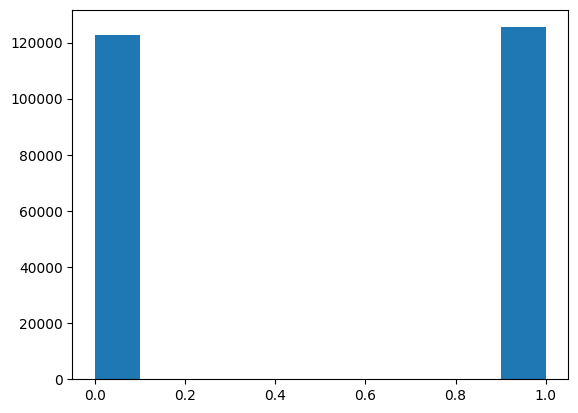

In [38]:
# Class balance
plt.hist(labels)
plt.show()

In [39]:
print('Number of samples per class:')
print('Active:', sum([l == 1 for l in labels]))
print('Inactive:', sum([l == 0 for l in labels]))

Number of samples per class:
Active: tensor(125432)
Inactive: tensor(122629)


In [31]:
augmentation.merge_symetric_behaviours_version2(indx_behaviour1=idx_sniffR, indx_behaviour2=idx_sniffV, dataset=train_dataset)
augmentation.rotate_samples(train_dataset, idx_sniffR)

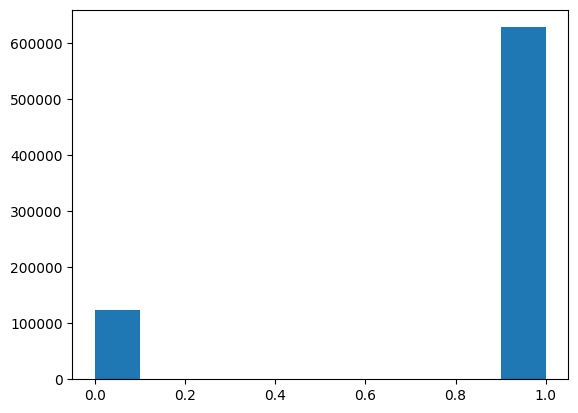

In [32]:
labels = [d.behaviour[idx_sniffR] for d in train_dataset]

# Class balance
plt.hist(labels)
plt.show()

In [23]:
print('Number of samples per class:')
print('Active:', sum([l == 1 for l in labels]))
print('Inactive:', sum([l == 0 for l in labels]))

Number of samples per class:
Active: tensor(77210)
Inactive: tensor(232859)


In [37]:
# Compute weights for the loss function
weights = [1/sum([l == 0 for l in labels]), 1/sum([l == 1 for l in labels])]

weights

[tensor(4.2944e-06), tensor(6.4758e-05)]

In [40]:
# Compute weights for the loss function
import sklearn.utils as skutils

weights_ = skutils.class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=np.array(labels))
weights_

array([1.01142878, 0.98882662])

In [64]:
train_dataset = augmentation.downsample_majority_class(train_dataset, idx_sniffR)

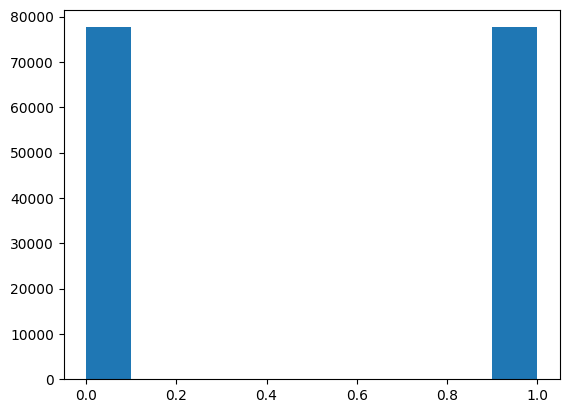

In [65]:
labels = [d.behaviour[idx_sniffR] for d in train_dataset]

# Class balance
plt.hist(labels)
plt.show()

In [66]:
print('Number of samples per class:')
print('Active:', sum([l == 1 for l in labels]).item())
print('Inactive:', sum([l == 0 for l in labels]).item())

Number of samples per class:
Active: 77625
Inactive: 77625


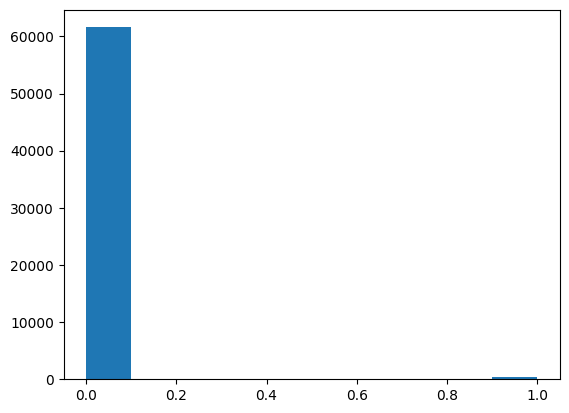

In [46]:
labels = [d.behaviour[idx_sniffR] for d in test_dataset]

# Class balance
plt.hist(labels)
plt.show()


In [47]:
print('Number of samples per class:')
print('Active:', sum([l == 1 for l in labels]).item())
print('Inactive:', sum([l == 0 for l in labels]).item())

Number of samples per class:
Active: 427
Inactive: 61589


In [10]:
# Keep only the idx_sniffR behaviour
for i in range(len(dataset)):
    dataset[i].behaviour = dataset[i].behaviour[idx_sniffR]

In [9]:
# Discard Nan's in the dataset
idx_to_keep = []
for i in range(len(dataset)):
    if dataset[i].behaviour != 0 and dataset[i].behaviour != 1:
        continue
    idx_to_keep.append(i)
    
        

In [10]:
dataset = [dataset[i] for i in idx_to_keep]

In [51]:
import sklearn.utils as skutils


In [52]:
len(labels)

248061

In [50]:
y = np.array(labels)

In [53]:
y.sum()

16618

In [54]:
np.unique(y)

array([0, 1], dtype=int64)

In [55]:
weights_ = skutils.class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

In [56]:
weights_

array([0.53590085, 7.46362378])

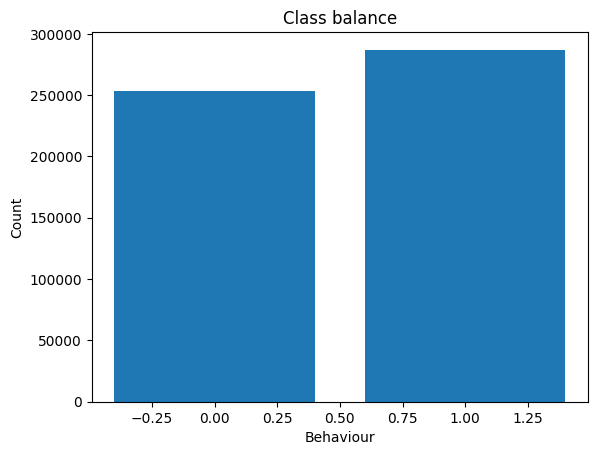

There are 540221 samples in the dataset
There are 253196 samples of behaviour 0
There are 287025 samples of behaviour 1


In [35]:
# Class balance 
behaviour = [d.behaviour.item() for d in dataset]
behaviour = np.array(behaviour)
behaviour = np.unique(behaviour, return_counts=True)

plt.bar(behaviour[0], behaviour[1])
plt.xlabel('Behaviour')
plt.ylabel('Count')
plt.title('Class balance')
plt.show()

print('There are {} samples in the dataset'.format(len(dataset)))
print('There are {} samples of behaviour 0'.format(behaviour[1][0]))
print('There are {} samples of behaviour 1'.format(behaviour[1][1]))


**only an specific behaviour**

In [90]:
if False:
    for i in range(len(dataset)):
        dataset[i].behaviour = dataset[i].behaviour[1]


In [75]:
dataset_cloned[0].behaviour

tensor([                   0,                    0, -9223372036854775808,
        -9223372036854775808,                    0,                    0,
                           0,                    0,                    0,
                           0,                    0])

In [94]:
len(dataset_cloned)

226040

## Class Balance

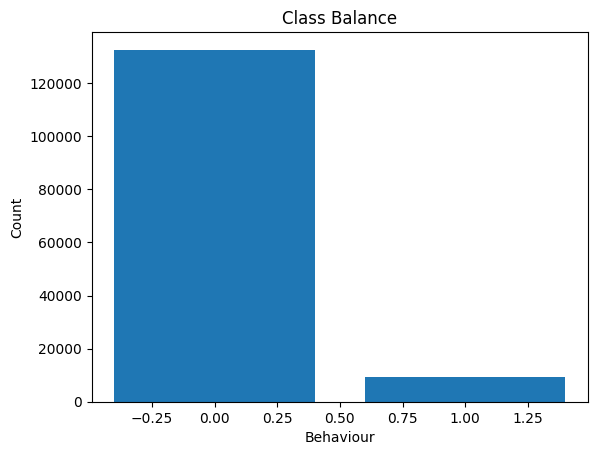

There are 9305 instances of the behaviour


In [95]:
# Class Balance
behaviour = [d.behaviour[2].item() for d in dataset_cloned]
behaviour = np.array(behaviour)
behaviour = np.unique(behaviour, return_counts=True)
#Plot
plt.bar(behaviour[0][1:], behaviour[1][1:])
plt.xlabel('Behaviour')
plt.ylabel('Count')
plt.title('Class Balance')
plt.show()

print('There are {} instances of the behaviour'.format(behaviour[1][2]))

In [96]:
# Rotate the dataset
augmentation.rotate_samples(dataset_cloned, idx_sniffR)

In [97]:
len(dataset_cloned)

263260

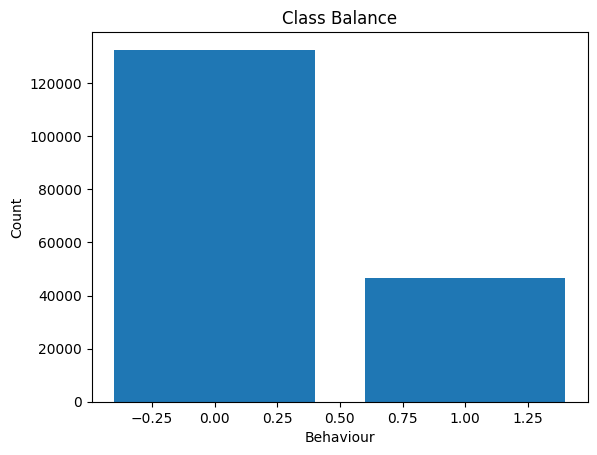

There are 46525 instances of the behaviour


In [98]:
# Class Balance
behaviour = [d.behaviour[2].item() for d in dataset_cloned]
behaviour = np.array(behaviour)
behaviour = np.unique(behaviour, return_counts=True)
#Plot
plt.bar(behaviour[0][1:], behaviour[1][1:])
plt.xlabel('Behaviour')
plt.ylabel('Count')
plt.title('Class Balance')
plt.show()

print('There are {} instances of the behaviour'.format(behaviour[1][2]))

In [99]:
ratio = behaviour[1][1] / behaviour[1][2]
print('The ratio between the two classes is {}'.format(ratio))

The ratio between the two classes is 2.8501880709296077


### Train-Test split

**Shuffle**

In [106]:
# Suffle the dataset
np.random.seed(0)
np.random.shuffle(dataset_cloned)

In [106]:
# Get only the first behaviour
for i in range(len(dataset)):
    dataset[i].behaviour = dataset[i].behaviour[0]

In [11]:
# Split train and test
train_size = int(0.8 * len(dataset))

train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

print('The train dataset has %d samples' % len(train_dataset))
print('The test dataset has %d samples' % len(test_dataset))

The train dataset has 248061 samples
The test dataset has 62016 samples


In [108]:
dataset[-1].behaviour

tensor(0)

### DataLoaders

In [12]:
batch_size = 32

# Create the dataloaders for train, validation and test
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

c:\Users\jalvarez\AppData\Local\anaconda3\envs\projenv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [24]:
for data in train_loader:
    a = data
    break

In [112]:
# Plot first batch 
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from(range(a.num_nodes))
G.add_edges_from(a.edge_index.T.tolist())
G.nodes
#nx.draw(G, with_labels=True)



NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [113]:
G.edges

EdgeView([(0, 0), (0, 18), (0, 19), (0, 20), (0, 22), (0, 23), (0, 27), (0, 28), (0, 29), (0, 30), (0, 34), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 34), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 34), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 34), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 34), (6, 6), (6, 7), (6, 8), (6, 9), (6, 

In [114]:
a.edge_index

tensor([[   0,    0,    0,  ..., 9503, 9503, 9503],
        [   0,   18,   19,  ..., 9500, 9501, 9502]])

KeyboardInterrupt: 

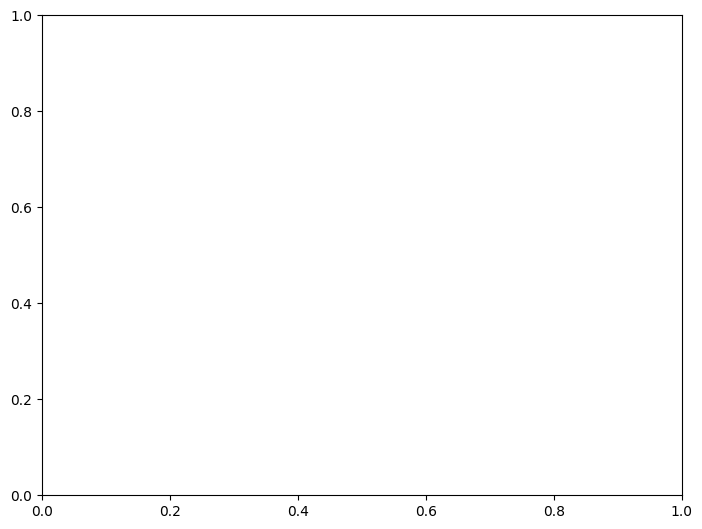

In [115]:
# Plot first batch

nx.draw(G, with_labels=True)

---

# Create Graphs

This will take a while, and i dont even know if it is going to work. jejeje

In [72]:
importlib.reload(models)

<module 'models' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\models.py'>

In [80]:
len(dataset_cloned)

NameError: name 'dataset_cloned' is not defined

In [25]:
for data in train_loader:
    a = data
    break

In [26]:
a.behaviour.shape

torch.Size([32])

In [119]:
a.frame_mask.unique()

tensor([   2,   14,   23,   42,   46,   48,   49,   50,   66,   67,   69,   74,
          93,  102,  103,  114,  115,  116,  122,  125,  165,  191,  200,  207,
         212,  224,  235,  250,  257,  260,  268,  284,  295,  309,  313,  325,
         346,  349,  380,  394,  398,  404,  413,  433,  442,  449,  459,  460,
         462,  463,  479,  480,  482,  493,  543,  546,  559,  564,  566,  577,
         580,  584,  586,  596,  612,  618,  622,  625,  633,  636,  663,  692,
         703,  731,  742,  758,  771,  785,  817,  821,  825,  828,  835,  849,
         887,  900,  906,  923,  926,  931,  937,  945,  971,  981, 1006, 1008,
        1014, 1051, 1064, 1078, 1095, 1097, 1108, 1111, 1123, 1150, 1151, 1164,
        1171, 1173, 1178, 1180, 1203, 1204, 1209, 1212, 1224, 1239, 1241, 1244,
        1265, 1273, 1281, 1289, 1299, 1300, 1303, 1308, 1310, 1324, 1339, 1351,
        1374, 1377, 1427, 1432, 1435, 1439, 1446, 1455, 1456, 1460, 1461, 1490,
        1528, 1558, 1574, 1585, 1588, 16

### Graph Classifier

In [73]:
graphencoder = models.GATEncoder(nout = 16, nhid=16, attention_hidden=2, n_in=4, dropout=0.5)
class_head = models.ClassificationHead(n_latent=576, nhid = 32, nout = 2)

In [76]:
lat = graphencoder(a.x, a.edge_index, a.frame_mask)

In [77]:
lat.shape

torch.Size([5760, 16])

In [78]:
embbed = concatenate_per_graph(lat, a.batch, a.frame_mask)

In [79]:
embbed.shape

torch.Size([32, 576])

In [80]:
out = class_head(embbed)

In [81]:
out.shape

torch.Size([32, 2])

In [68]:
dataset[0]

Data(x=[180, 4], edge_index=[2, 2054], file='DMD_mal_Test_23DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', frame_mask=[180], behaviour=0, behaviour_names=Index(['General_Contacts', 'Sniffing_R', 'Sniffing_head_R', 'Sniffing_other_R',
       'Sniffing_anal_R', 'Poursuit_R', 'Dominance_R', 'Rearing_R',
       'Grooming_R', 'Sniffing_V', 'Sniffing_head_V', 'Sniffing_other_V',
       'Sniffing_anal_V', 'Poursuit_V', 'Dominance_V', 'Rearing_V',
       'Grooming_V'],
      dtype='object'))

In [69]:
model = models.SimpleMLPforGraph(144, 100, 2)

In [47]:
def concatenate_per_graph(embbed, batch, frame_mask):
        ''' Concatenate the embeddings per graph '''
        out = []
        for i in range(batch.max()+1):
            out.append(embbed[batch==i][frame_mask[batch==i] == frame_mask[batch==i].median()].flatten())
        return torch.stack(out)

In [22]:
out = model(a)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x720 and 144x100)

In [127]:
out.shape

torch.Size([264, 2])

In [88]:
lat.shape

torch.Size([5760, 16])

In [89]:
# Per node frame-level aggragation
embbed = concatenate_per_graph(lat, a.batch, a.frame_mask)

In [90]:
embbed.shape

torch.Size([32, 576])

In [91]:
out = class_head(embbed)

In [92]:
out.shape

torch.Size([32, 2])

In [82]:
model = models.GraphClassifier(graphencoder, class_head)

In [83]:
out = model(a)

In [84]:
out.shape

torch.Size([32, 2])

In [85]:
print('The model has %d trainable parameters' % sum(p.numel() for p in model.parameters() if p.requires_grad))

The model has 23186 trainable parameters


In [86]:
import tqdm

#### Trainning Loop

In [87]:
# Trainning loop
num_epochs = 10
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter(log_dir='runs/TESTTTT')  # TensorBoard writer
actual_epoch = 0

In [88]:
start_time = time.time()  # Time the training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    correct_class_0 = 0
    correct_class_1 = 0
    total_class_0 = 0
    total_class_1 = 0
    total = 0
    i = 0

    for data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        labels = data.behaviour

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        correct_class_0 += (predicted[labels == 0] == labels[labels == 0]).sum().item()
        correct_class_1 += (predicted[labels == 1] == labels[labels == 1]).sum().item()
        total_class_0 += (labels == 0).sum().item()
        total_class_1 += (labels == 1).sum().item()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Log training loss and accuracy at each step
        if i % 100 == 0:  # Log every 100 iterations, adjust as needed
            writer.add_scalar('Loss/Train', loss.item(), (actual_epoch + epoch) * len(train_loader) + i)
            writer.add_scalar('Accuracy/Train', correct / total, (actual_epoch + epoch) * len(train_loader) + i)
        i += 1

    train_accuracy = correct / total
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch + actual_epoch + 1}, Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    correct_class_0 = 0
    correct_class_1 = 0
    total_class_0 = 0
    total_class_1 = 0
    total = 0
    with torch.no_grad():
        for val_data in tqdm.tqdm(test_loader):
            val_outputs = model(val_data)
            val_labels = val_data.behaviour
            val_loss += criterion(val_outputs, val_labels).item()
            val_predicted = val_outputs.argmax(dim=1)
            correct_class_0 += (val_predicted[val_labels == 0] == val_labels[val_labels == 0]).sum().item()
            correct_class_1 += (val_predicted[val_labels == 1] == val_labels[val_labels == 1]).sum().item()
            total_class_0 += (val_labels == 0).sum().item()
            total_class_1 += (val_labels == 1).sum().item()
            correct += (val_predicted == val_labels).sum().item()
            total += val_labels.size(0)

    val_accuracy = correct / total
    avg_val_loss = val_loss / len(test_loader)

    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}")

    # Log validation metrics
    writer.add_scalar('Loss/Validation', avg_val_loss, actual_epoch + epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, actual_epoch + epoch)
    writer.add_scalar('Accuracy/Avarage_inactive_class_Validation', correct_class_0 / total_class_0, actual_epoch + epoch)
    writer.add_scalar('Accuracy/Avarage_active_class_Validation', correct_class_1 / total_class_1, actual_epoch + epoch)
    writer.add_scalar('Accuracy/Average_per_class_Validation', ((correct_class_0 / total_class_0) + (correct_class_1 / total_class_1)) / 2, actual_epoch + epoch)

    # Step the scheduler
    #scheduler.step()

    # Log learning rate
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, actual_epoch + epoch)
    print(f"Learning Rate after epoch {epoch + 1}: {current_lr}")

    # Save checkpoint after each 5 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + actual_epoch + 1}.pth')
        save_checkpoint(model, optimizer, epoch + 1, avg_train_loss, checkpoint_path)

# Save the final model
if num_epochs % 5 != 0:
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + actual_epoch + 1}.pth')
    save_checkpoint(model, optimizer, epoch + 1, avg_train_loss, checkpoint_path)


  0%|          | 22/7752 [00:04<25:07,  5.13it/s]


KeyboardInterrupt: 

---

## Load trained model


In [13]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    # Save the model, optimizer state, epoch, and loss
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at {path}")

In [14]:
# Load the model
def load_checkpoint(model, optimizer, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {path}, at epoch {epoch}")
    return model, optimizer, epoch

In [144]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load the data
dataset = torch.load(r'c:\Users\jalvarez\Documents\Data\LargeDataset\entire_dataset.pkl', map_location=device)

# Suffle the dataset
np.random.seed(0)
np.random.shuffle(dataset)



cpu


PermissionError: [Errno 13] Permission denied: 'c:\\Users\\jalvarez\\Documents\\Data\\DataLoadaerTESTTSTST'

In [20]:
len(dataset)

310077

In [21]:
dataset[0].behaviour_names


Index(['General_Contacts', 'Sniffing_R', 'Sniffing_head_R', 'Sniffing_other_R',
       'Sniffing_anal_R', 'Poursuit_R', 'Dominance_R', 'Rearing_R',
       'Grooming_R', 'Sniffing_V', 'Sniffing_head_V', 'Sniffing_other_V',
       'Sniffing_anal_V', 'Poursuit_V', 'Dominance_V', 'Rearing_V',
       'Grooming_V'],
      dtype='object')

In [22]:
dataset[0].behaviour

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
# get only the behaviour of interest
idx_to_keep = []
for i in range(len(dataset)):
    # If NaN, discard the sample
    if dataset[i].behaviour[3] != 0 and dataset[i].behaviour[3] != 1:
        continue
    else:
        dataset[i].behaviour = dataset[i].behaviour[3]
        idx_to_keep.append(i)

In [16]:
test_dataset = [dataset[i] for i in idx_to_keep]

In [17]:
len(test_dataset)

141897

In [18]:
# Delete the dataset
del dataset

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
importlib.reload(models)
# Define the model
graphencoder = models.GATEncoder(nout = 8, nhid=16, attention_hidden=2, n_in=4, dropout=0.5)
class_head = models.ClassificationHead(n_latent=576, nhid = 32, nout = 2)

model = models.GraphClassifier(graphencoder, class_head)

model.to(device)


GraphClassifier(
  (encoder): GATEncoder(
    (relu): ReLU()
    (gatenc1): GATv2Conv(4, 16, heads=2)
    (gatenc2): GATv2Conv(32, 16, heads=2)
    (gatenc3): GATv2Conv(32, 16, heads=2)
    (res_conn): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (classifier): ClassificationHead(
    (hidden1): Linear(in_features=576, out_features=32, bias=True)
    (hidden2): Linear(in_features=32, out_features=32, bias=True)
    (hidden3): Linear(in_features=32, out_features=2, bias=True)
    (relu): ReLU()
  )
)

In [21]:
checkpoint = torch.load(r'c:\Users\jalvarez\Documents\Data\Checkpoints\Dominance\checkpoint_epoch_160_without_weights', map_location=device)

In [111]:
checkpoint['model_state_dict'].keys()

odict_keys(['encoder.gatenc1.att', 'encoder.gatenc1.bias', 'encoder.gatenc1.lin_l.weight', 'encoder.gatenc1.lin_l.bias', 'encoder.gatenc1.lin_r.weight', 'encoder.gatenc1.lin_r.bias', 'encoder.gatenc2.att', 'encoder.gatenc2.bias', 'encoder.gatenc2.lin_l.weight', 'encoder.gatenc2.lin_l.bias', 'encoder.gatenc2.lin_r.weight', 'encoder.gatenc2.lin_r.bias', 'encoder.gatenc3.att', 'encoder.gatenc3.bias', 'encoder.gatenc3.lin_l.weight', 'encoder.gatenc3.lin_l.bias', 'encoder.gatenc3.lin_r.weight', 'encoder.gatenc3.lin_r.bias', 'encoder.res_conn.0.weight', 'encoder.res_conn.0.bias', 'classifier.hidden1.weight', 'classifier.hidden1.bias', 'classifier.hidden2.weight', 'classifier.hidden2.bias', 'classifier.hidden3.weight', 'classifier.hidden3.bias'])

In [23]:
# Try on the entire dataset

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [24]:
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)


In [25]:
# Load the model
checkpoint_path = r'c:\Users\jalvarez\Documents\Data\Checkpoints\Dominance\checkpoint_epoch_400.pth'
model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path, device)

Checkpoint loaded from c:\Users\jalvarez\Documents\Data\Checkpoints\Dominance\checkpoint_epoch_400.pth, at epoch 200


In [26]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for val_data in tqdm.tqdm(test_loader):
        val_outputs = model(val_data)
        val_labels = val_data.behaviour
        val_predicted = val_outputs.argmax(dim=1)
        y_true.extend(val_labels.tolist())
        y_pred.extend(val_predicted.tolist())

100%|██████████| 4435/4435 [07:07<00:00, 10.37it/s]


In [27]:
val_data.behaviour[1]

tensor(0)

In [28]:
print('Ther are %d samples' % len(y_true))
print('There are %d cases of not following' % y_true.count(0))
print('There are %d cases of following' % y_true.count(1))

Ther are 141897 samples
There are 131586 cases of not following
There are 10311 cases of following


In [29]:
# accuracy
correct = sum([1 for i in range(len(y_true)) if y_true[i] == y_pred[i]])
accuracy = correct / len(y_true)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8399966172646356


In [30]:
# Accuracy per class

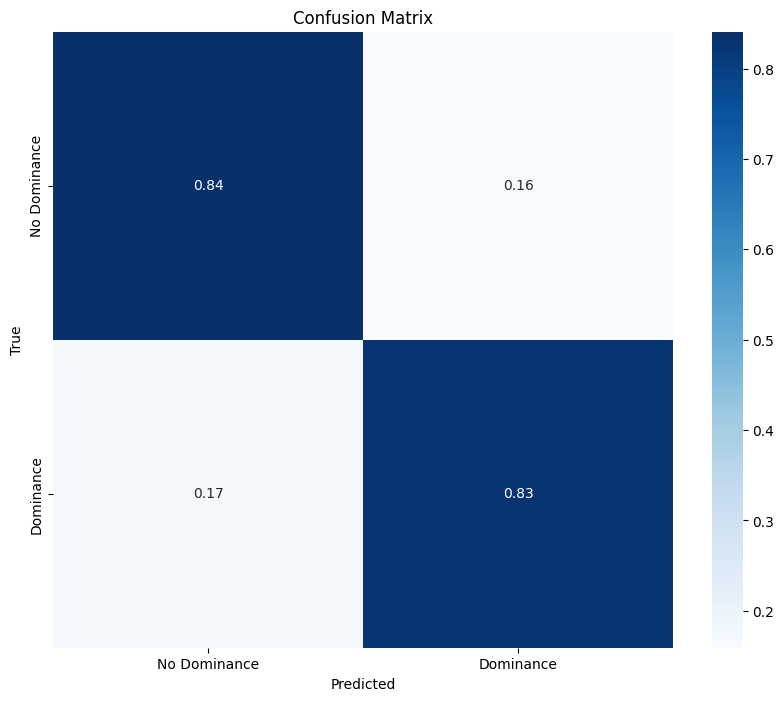

In [32]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Percentage plot of the confusion matrix
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['No Dominance', 'Dominance'], yticklabels=['No Dominance', 'Dominance'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [121]:
# Load the model
checkpoint_path = r'c:\Users\jalvarez\Documents\Data\Checkpoints\Grooming\checkpoint_epoch_190.pth'
model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path, device)

Checkpoint loaded from c:\Users\jalvarez\Documents\Data\Checkpoints\Grooming\checkpoint_epoch_190.pth, at epoch 190


In [124]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for val_data in tqdm.tqdm(test_loader):
        val_outputs = model(val_data)
        val_labels = val_data.behaviour
        val_predicted = val_outputs.argmax(dim=1)
        y_true.extend(val_labels.tolist())
        y_pred.extend(val_predicted.tolist())

100%|██████████| 7064/7064 [14:16<00:00,  8.24it/s]


Ther are 226040 samples
There are 224557 cases of not following
There are 1483 cases of following
Accuracy: 0.9207529640771545


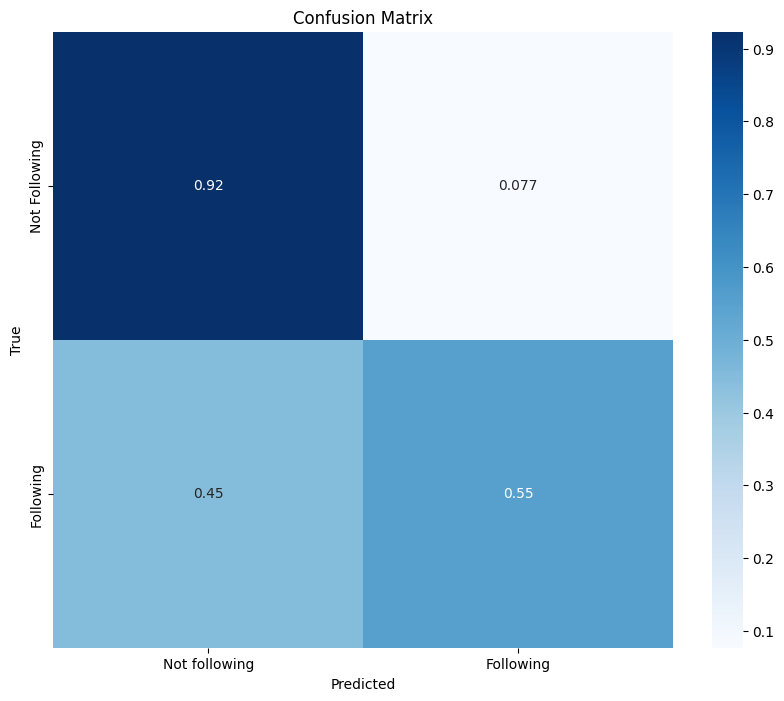

In [125]:
print('Ther are %d samples' % len(y_true))
print('There are %d cases of not following' % y_true.count(0))
print('There are %d cases of following' % y_true.count(1))

# accuracy
correct = sum([1 for i in range(len(y_true)) if y_true[i] == y_pred[i]])
accuracy = correct / len(y_true)
print(f"Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Percentage plot of the confusion matrix
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Not following', 'Following'], yticklabels=['Not Following', 'Following'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [122]:
import augmentation

In [123]:
# Load the data
dataset = torch.load(r'c:\Users\jalvarez\Documents\Data\Dataset_DMDmaleMDX5CVmalefem\dataset_large.pkl', map_location=device)

# Select the behaviour to classify (Dominance in this case)
indx_behaviour1 = 3
indx_behaviour2 = 8

# Suffle the dataset
np.random.seed(0)
np.random.shuffle(dataset)


KeyboardInterrupt: 

In [73]:
# get only the behaviour of interest
idx_to_keep = []
for i in range(len(dataset)):
    # If NaN, discard the sample
    if dataset[i].behaviour[2] != 0 and dataset[i].behaviour[2] != 1:
        continue
    else:
        idx_to_keep.append(i)

In [74]:
dataset = [dataset[i] for i in idx_to_keep]

In [25]:
# Suffle the dataset
np.random.seed(0)
np.random.shuffle(dataset)

In [26]:

# Split train and test
train_size = int(0.8 * len(dataset))

train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]


In [27]:
print(len(dataset))
print(train_size)

310077
248061


In [77]:


print('Merging the behaviours')
augmentation.merge_symetric_behaviours(indx_behaviour1, indx_behaviour2, train_dataset)
print('Generating rotation augmentation')
# Rotate the dataset
augmentation.rotate_samples(train_dataset, indx_behaviour1)
print('Downsampling the inactive behaviours')
train_dataset = augmentation.downsample_inactive(train_dataset, indx_behaviour1)

for i in range(len(train_dataset)):
    train_dataset[i].behaviour = train_dataset[i].behaviour[indx_behaviour1]
for i in range(len(test_dataset)):
    test_dataset[i].behaviour = test_dataset[i].behaviour[indx_behaviour1]
print('Done selecting the behaviour')


Merging the behaviours
Generating rotation augmentation
Downsampling the inactive behaviours
Done selecting the behaviour


In [78]:
# Discard NaNs samples

In [79]:
print('The train dataset has %d samples' % len(train_dataset))
print('The test dataset has %d samples' % len(test_dataset))

The train dataset has 90550 samples
The test dataset has 28380 samples


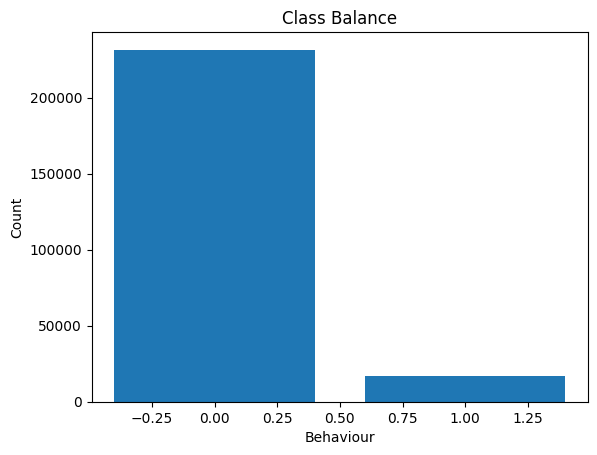

In [31]:
# Class balance
behaviour = [d.behaviour[2] for d in train_dataset]
behaviour = np.array(behaviour)
behaviour = np.unique(behaviour, return_counts=True)
# Plot
plt.bar(behaviour[0], behaviour[1])
plt.xlabel('Behaviour')
plt.ylabel('Count')
plt.title('Class Balance')
plt.show()


In [ ]:
# weights
weights = skutils.class_weight.compute_class_weight('balanced', np.unique(behaviour[0]), behaviour[0])

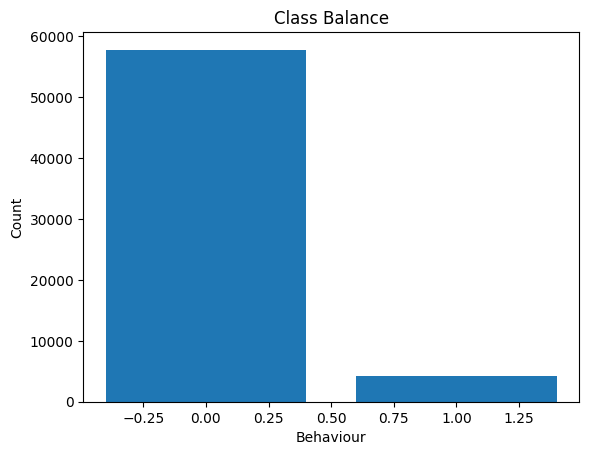

In [30]:
# class balance test
behaviour = [d.behaviour[2] for d in test_dataset]
behaviour = np.array(behaviour)
behaviour = np.unique(behaviour, return_counts=True)
# Plot
plt.bar(behaviour[0], behaviour[1])
plt.xlabel('Behaviour')
plt.ylabel('Count')
plt.title('Class Balance')
plt.show()


---

---

---

---

---

---

#### eDIT NAMES

In [23]:
path = r'c:\Users\jalvarez\Documents\Data\DEEPLABCUT_needs_this_folder_I_dont_like_dlc'

# replace ' ' by '_'
for filename in os.listdir(path):
    os.rename(os.path.join(path, filename), os.path.join(path, filename.replace(' ', '_')))

---

In [48]:
import pandas as pd

In [54]:
data_dlc = DataDLC.DataDLC(r'c:\Users\jalvarez\Documents\Data\DataLoadaerTESTTSTST\DMD_mal_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5')

data_dlc.drop_tail_bodyparts()

coords = data_dlc.coords.to_numpy()

In [61]:
coords.shape
# Reshape coords as (n_frames, n_individuals, n_bodyparts, 3)
coords = coords.reshape((coords.shape[0], data_dlc.n_individuals, data_dlc.n_body_parts, 3))

dtype('float64')